In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import talib

# Multiple linear regression model and Data Loading functions

In [3]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    #remove weekends

    print(data.head())
    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    data['50_sma'] = data['Close'].rolling(window=50).mean() #add 50 moving average
    data['200_sma'] = data['Close'].rolling(window=200).mean() #add 200 moving average
    data['12_ema'] =  data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    # Data Processing: Add target variable: closing price at the next time step
    data['NextTimeStepClosing'] = data['Close'].shift(-1) #shift closing price to create target

    data = data.dropna() # drop rows that have NA

    #select subset of data 
    data = data[-3500:]

    # Features: data of the current time step
    time = data['Time']
    X = data[['Open','High', 'Low', 'Close', 'Volume', '50_sma','200_sma']]  #features

    Y = data['NextTimeStepClosing']    #target - closing price of next time

    return X, Y, time

# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Data loading, Model Training and Performance Evaluation

In [4]:
# Load data
file_path = './Data/EURUSD_D1.csv'  # Replace with your CSV file path
X, y, time = load_data(file_path)

# Split data into training and test sets
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

sma_50_test = X_test['50_sma']
sma_200_test = X_test['200_sma']

# Standardize features - unless volume added, not needed: done so model can weigh each feature fairly
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mbe = np.mean(y_pred_test - y_test) # mean bias error
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}\nTest MAE: {test_mae*100}%\nTest MBE: {test_mbe*100}% \nTest Coefficient of determination:{test_r2}')

'''
Data Processing: Re-Align test data and time and reset index
'''
y_test = y_test.reset_index(drop=True).iloc[1:] # exclude first row and reset index
time_test = time_test.reset_index(drop=True).iloc[1:]
y_pred_test = pd.Series(y_pred_test).shift(1) #convert prediction to a series
y_pred_test = y_pred_test.dropna()

# Re-align 50 EMA to match the test set
sma_50_test = sma_50_test.reset_index(drop=True).iloc[1:]
sma_200_test = sma_200_test.reset_index(drop=True).iloc[1:]


#Construct dataframe for easy plotting 
resultsDataFrame= pd.DataFrame({
    'Date and Time': time_test,
    'Actual closing': y_test,
    'Fore. Closing': y_pred_test,
    '50 SMA': sma_50_test,
    '200 SMA': sma_200_test

})


        Time     Open     High      Low    Close  Volume
0 2008-08-01  1.55575  1.55886  1.55142  1.55609  755330
1 2008-08-03  1.55638  1.55790  1.55586  1.55658   76728
2 2008-08-04  1.55662  1.56306  1.55526  1.55638  858293
3 2008-08-05  1.55624  1.55646  1.54442  1.54640  858740
4 2008-08-06  1.54650  1.55167  1.53956  1.54195  850798
Training MSE: 3.5476320960087376e-05
Test MSE: 3.233775681154524e-05
Test MAE: 0.41949199744721166%
Test MBE: -0.03181225413805638% 
Test Coefficient of determination:0.9704992866196809


# Plot of Prediction and Forecasted Price

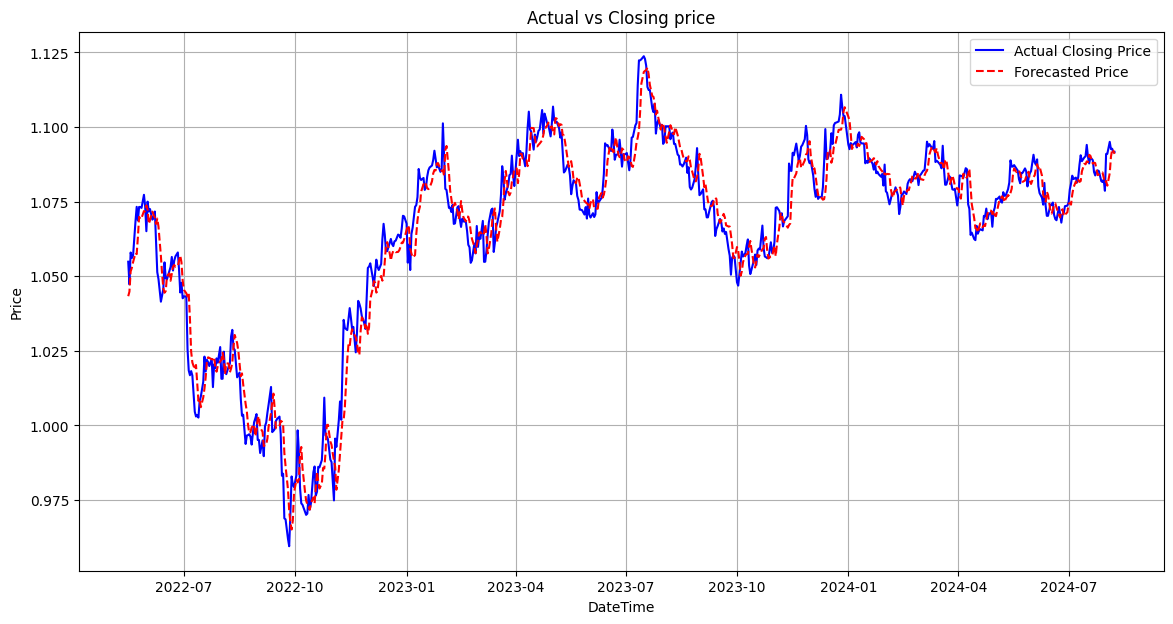

In [5]:
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 EMA', color='green', linestyle='-')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='50 EMA', color='blue', linestyle='-')

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Closing price')
plt.legend()
plt.grid(True)
plt.show()

# Trading strategy and Signal generation

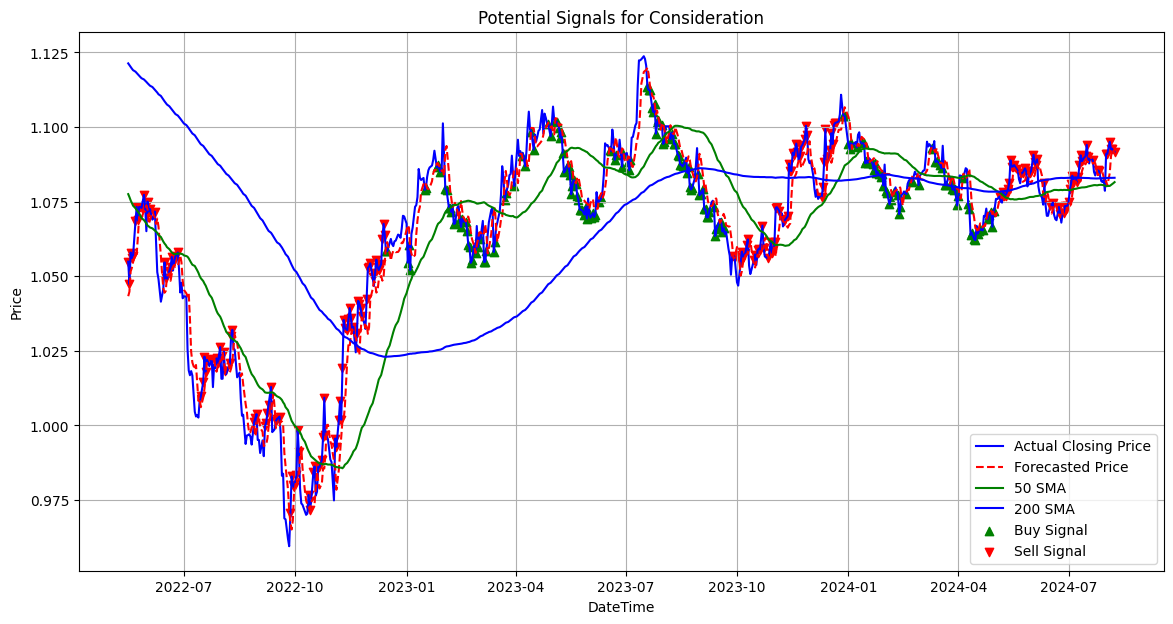

In [6]:
#generate trading signals -  store list of tuples
buy_signals =[]
sell_signals =[]


for i in range(len(y_test)):
    # Check if the 50 SMA is above the 200 SMA for a buy signal
    if (resultsDataFrame['50 SMA'].iloc[i] > resultsDataFrame['200 SMA'].iloc[i]):
        # Enter long position if predicted close > actual close and 50SMA > 200SMA
        if y_pred_test.iloc[i] > y_test.iloc[i]:
            buy_signals.append((time_test.iloc[i], y_test.iloc[i]))
            sell_signals.append((None, None))
        else:
            buy_signals.append((None, None))
            sell_signals.append((None, None))
    
    # Check if the 50 SMA is below the 200 SMA for a sell signal
    elif (resultsDataFrame['50 SMA'].iloc[i] < resultsDataFrame['200 SMA'].iloc[i]):
        # Enter short position if predicted close < actual close and 50SMA < 200SMA
        if y_pred_test.iloc[i] < y_test.iloc[i]:
            sell_signals.append((time_test.iloc[i], y_test.iloc[i]))
            buy_signals.append((None, None))
        else:
            buy_signals.append((None, None))
            sell_signals.append((None, None))
    
    # If neither condition is met, no trade opportunity
    else:
        buy_signals.append((None, None))
        sell_signals.append((None, None))

# Extract times and prices for plotting
buy_times = [signal[0] for signal in buy_signals if signal[0] is not None]
buy_prices = [signal[1] for signal in buy_signals if signal[1] is not None]
sell_times = [signal[0] for signal in sell_signals if signal[0] is not None]
sell_prices = [signal[1] for signal in sell_signals if signal[1] is not None]


# Plot buy and sell signals
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'blue',linestyle='--')

plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='blue', linestyle='-')


plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Potential Signals for Consideration')
plt.legend()
plt.grid(True)
plt.show()


# Trade Execution and Returns evaluation - BackTesting

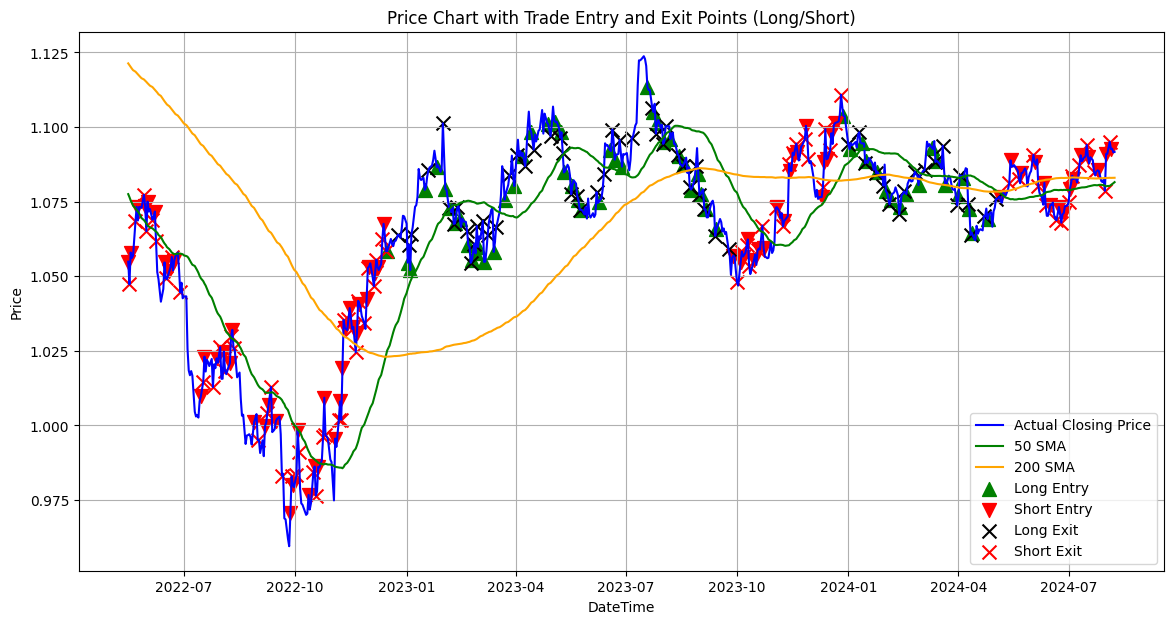

Total Trades: 131
Winning Trades: 59
Losing Trades: 72
Win Rate: 45.04%
Cumulative Pips: -9.30


In [7]:
# Initialize variables for backtesting
capital = 100000  # Starting capital in dollars (or any unit)
position = None  # Keeps track of the current position ('long', 'short', or None)
entry_price = 0  # The price at which the position was entered
pips_per_trade = 0  # To track pips gained/lost in each trade
cumulative_pips = 0  # To track cumulative pips gained/lost over time
pips_list = []  # Track pips gained/lost per trade

# Initialize lists to track long and short entry points separately
long_entry_points = []  # For long positions
short_entry_points = []  # For short positions
exit_points = []  # For exit points (both long and short)

long_exit_points = []  # For long position exits
short_exit_points = []  # For short position exits

# Define take profit and stop loss (in pips)
take_profit_pips = 50
stop_loss_pips = 30

# Convert pips to actual price movement for EURUSD (1 pip = 0.0001)
pip_value = 0.0001

# Backtesting loop
for i in range(len(y_test)):
    # Buy Signal (Enter Long)
    if buy_signals[i][0] is not None and position is None:
        position = 'long'
        entry_price = y_test.iloc[i]
        entry_time = time_test.iloc[i]
        long_entry_points.append((entry_time, entry_price))  # Track long entry point

    # Sell Signal (Enter Short)
    elif sell_signals[i][0] is not None and position is None:
        position = 'short'
        entry_price = y_test.iloc[i]
        entry_time = time_test.iloc[i]
        short_entry_points.append((entry_time, entry_price))  # Track short entry point

    # Exit Long Position
    elif position == 'long':
        # Calculate pips gained
        price_diff = y_test.iloc[i] - entry_price
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            # exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point
            long_exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track long exit point

            position = None  # Exit trade

    # Exit Short Position
    elif position == 'short':
        # Calculate pips gained (inverse for short)
        price_diff = entry_price - y_test.iloc[i]
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            # exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point
            short_exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track short exit point

            position = None  # Exit trade

# Extract entry and exit times and prices for plotting
long_entry_times = [point[0] for point in long_entry_points]
long_entry_prices = [point[1] for point in long_entry_points]
short_entry_times = [point[0] for point in short_entry_points]
short_entry_prices = [point[1] for point in short_entry_points]

# exit_times = [point[0] for point in exit_points]
# exit_prices = [point[1] for point in exit_points]

long_exit_times = [point[0] for point in long_exit_points]
long_exit_prices = [point[1] for point in long_exit_points]
short_exit_times = [point[0] for point in short_exit_points]
short_exit_prices = [point[1] for point in short_exit_points]

# Plot the price chart with long and short entry points and exit points
plt.figure(figsize=(14, 7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='orange', linestyle='-')

# Plot long entry points (e.g., green triangle)
plt.scatter(long_entry_times, long_entry_prices, marker='^', color='green', label='Long Entry', alpha=1, s=100)

# Plot short entry points (e.g., red triangle)
plt.scatter(short_entry_times, short_entry_prices, marker='v', color='red', label='Short Entry', alpha=1, s=100)

# Plot exit points (e.g., black cross)
# plt.scatter(exit_times, exit_prices, marker='x', color='black', label='Exit Point', alpha=1, s=100)

# Plot long exit points (e.g., black cross)
plt.scatter(long_exit_times, long_exit_prices, marker='x', color='black', label='Long Exit', alpha=1, s=100)

# Plot short exit points (e.g., blue cross)
plt.scatter(short_exit_times, short_exit_prices, marker='x', color='red',label='Short Exit', alpha=1, s=100 )

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Price Chart with Trade Entry and Exit Points (Long/Short)')
plt.legend()
plt.grid(True)
plt.show()

# After the loop: Analyze the strategy performance
total_trades = len(pips_list)
winning_trades = len([p for p in pips_list if p > 0])
losing_trades = total_trades - winning_trades
win_rate = winning_trades / total_trades if total_trades > 0 else 0

# Display the backtesting results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Cumulative Pips: {cumulative_pips:.2f}")



# Visualsizing Backtest results

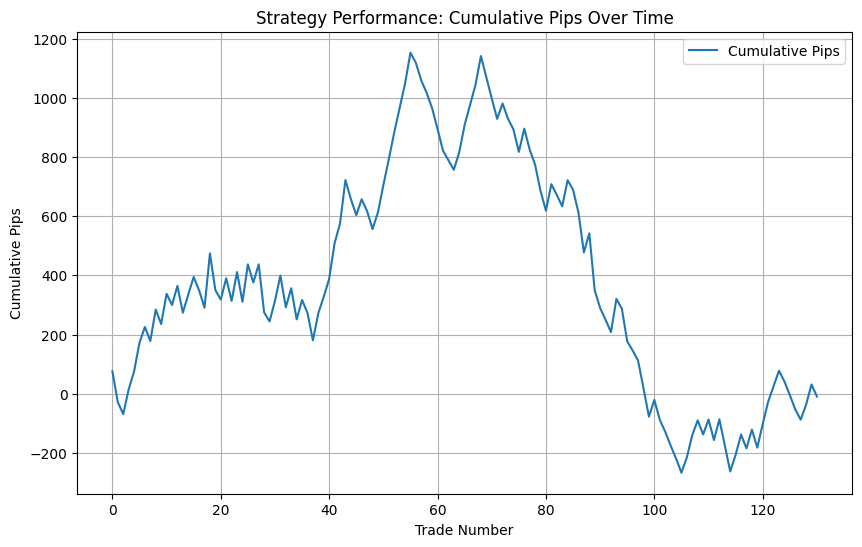

In [8]:
# Plot cumulative pips over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(pips_list)), [sum(pips_list[:i+1]) for i in range(len(pips_list))], label='Cumulative Pips')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Pips')
plt.title('Strategy Performance: Cumulative Pips Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Part 2: Data Inspection

               Open     High      Low    Close  Volume  Close_diff
Time                                                              
2008-08-01  1.55575  1.55886  1.55142  1.55609  755330         NaN
2008-08-03  1.55638  1.55790  1.55586  1.55658   76728     0.00049
2008-08-04  1.55662  1.56306  1.55526  1.55638  858293    -0.00020
2008-08-05  1.55624  1.55646  1.54442  1.54640  858740    -0.00998
2008-08-06  1.54650  1.55167  1.53956  1.54195  850798    -0.00445


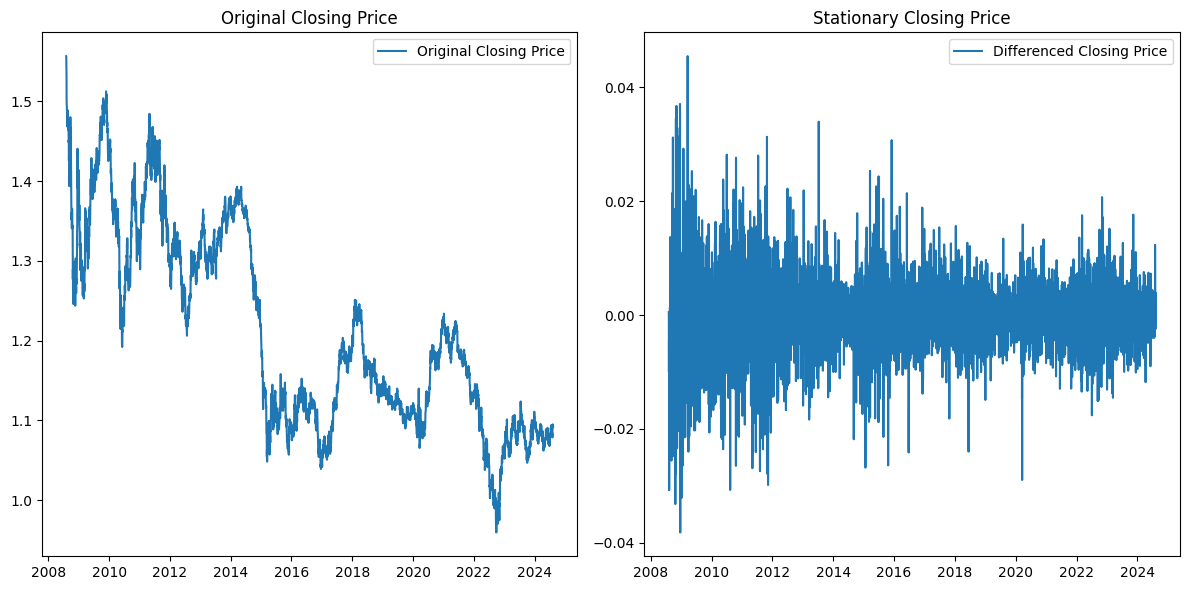

In [61]:
# Data loading
def data_loader(filepath):
    data = pd.read_csv(filepath)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    return data

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -3].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -3])  # The target value

    feature_columns = [f'n_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    data = pd.concat([X_df, Y_df], axis=1)

    return data, X_df,Y_df

filepath = './Data/EURUSD_D1.csv' 
datasetX = data_loader(filepath)

datasetX['Time'] = pd.to_datetime(datasetX['Time'],format='%Y-%m-%d %H:%M:%S')
datasetX.set_index('Time', inplace=True)

# Make the target (Closing price) stationary
datasetX['Close_diff'] = datasetX['Close'].diff()  # First difference of Closing price
print(datasetX.head())
datasetX.dropna(inplace=True)

# Create a figure and two subplots side by side
plt.figure(figsize=(12, 6))

# First subplot - Original Closing Price
plt.subplot(1, 2, 1)
plt.plot(datasetX['Close'], label='Original Closing Price')
plt.title('Original Closing Price')
plt.legend()

# Second subplot - Differenced Closing Price
plt.subplot(1, 2, 2)
plt.plot(datasetX['Close_diff'], label='Differenced Closing Price')
plt.title('Stationary Closing Price')
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()



# Forecasting with stationary data

# Auto correlation Plot

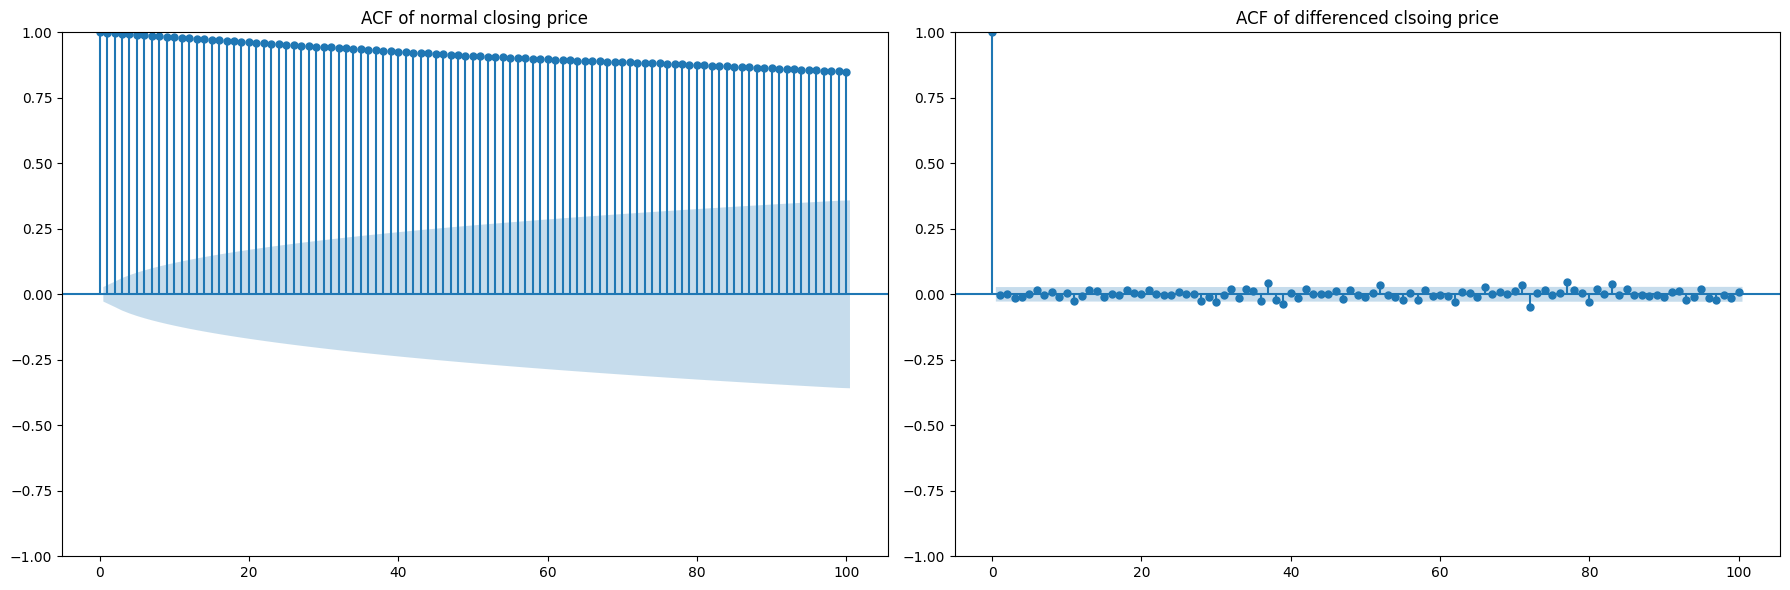

'\nBased on plot, there is a strong correlation between closing price and the previous lags\nWant features that will tell you something about the response\nThus lag of 10 var chosen\n'

In [62]:
from statsmodels.graphics.tsaplots import plot_acf

#return dataset
lag_window_period = 5
featuresAndresponse, X, Y = featureEngineering(datasetX, lag_window_period)

lags = 100 #extend the ACF plot to include more lags

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#Autocorralation plot on response
plot_acf(featuresAndresponse['response'], lags = lags, ax=axes[0])
axes[0].set_title('ACF of normal closing price')


#Autocorrelation in the difference closing price
plot_acf(datasetX['Close_diff'] , lags = lags,ax=axes[1])
axes[1].set_title('ACF of differenced clsoing price')

plt.tight_layout()
plt.show()
'''
Based on plot, there is a strong correlation between closing price and the previous lags
Want features that will tell you something about the response
Thus lag of 10 var chosen
'''

# Feature Importance of Lag variable

/home/dgibrilly/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[5.25971648e-04 4.71516991e-04 5.36294862e-04 8.17073336e-04
 9.97649143e-01]


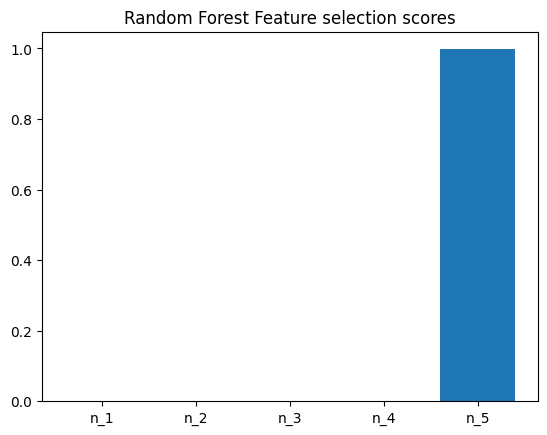

['n_1' 'n_2' 'n_3' 'n_4' 'n_5'] [0, 1, 2, 3, 4]


'\nResults are strange: Highest score given to variable at the End\n'

In [63]:
#Feature importance score of Lag variables: Score can be determined by ensemble of decision trees \

from sklearn.ensemble import RandomForestRegressor

# split into input and output
feature_values =  X.values
respons_values = Y.values

#Fit random forest model
modelRF = RandomForestRegressor(n_estimators=10, random_state=1)
modelRF.fit(feature_values, respons_values)

# show importance scores
print(modelRF.feature_importances_)

# plot importance scores
names = featuresAndresponse.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, modelRF.feature_importances_)
plt.title('Random Forest Feature selection scores')
plt.xticks(ticks, names)
plt.show()

print(names, ticks)

'''
Results are strange: Highest score given to variable at the End
'''

# Univariate FORECASTING USING N>1 previous time steps

Training MSE: 0.0002696615581161275
Test MSE: 0.0003968664657967383
Test MAE: 1.8158055490919398%
Test MBE: 1.8115486502875568% 
Test Coefficient of determination:0.845837077153061


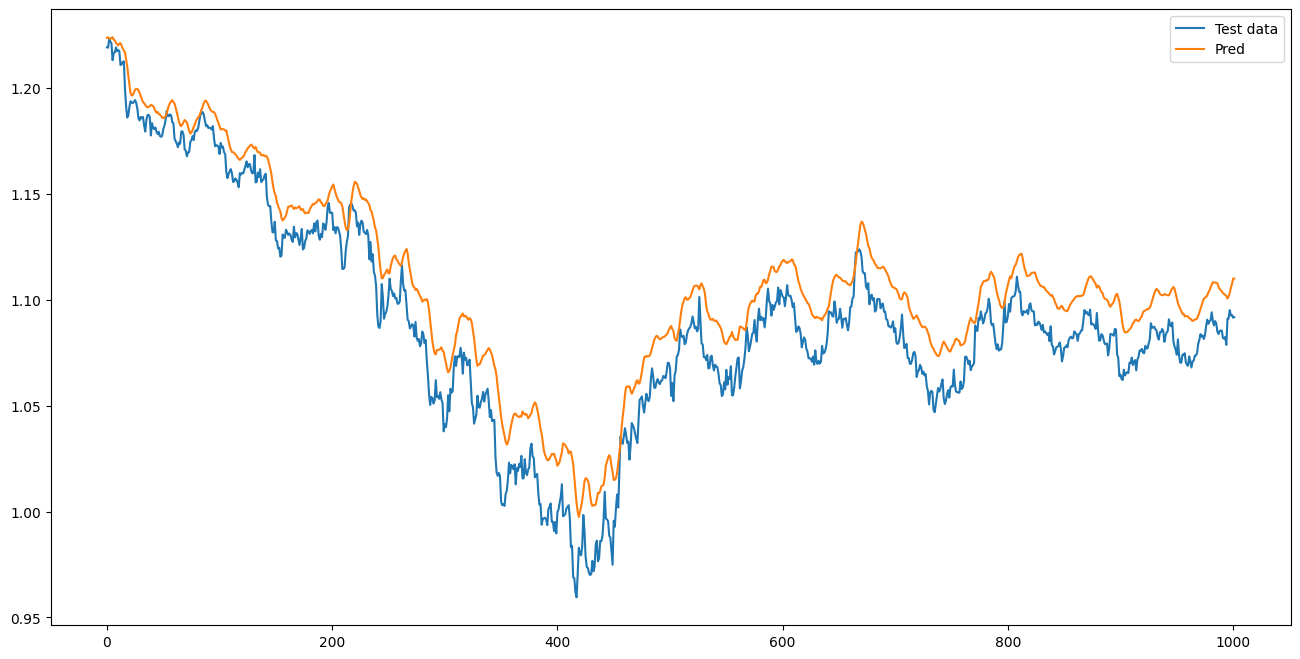

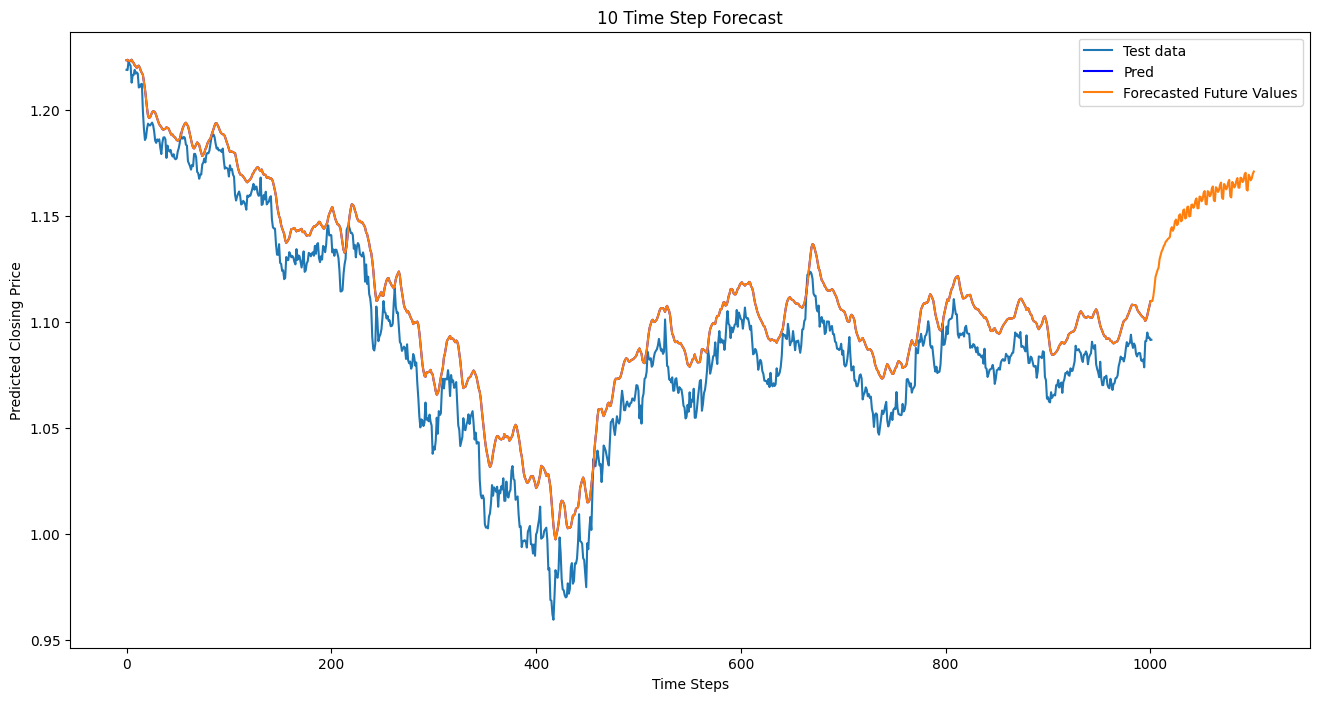

'\nNOTE: Performance greatly improces when standardizing data\n'

In [145]:

#data split
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=42, shuffle=False)

# Reshape y_train and y_test from DataFrame to 1D array or Series
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()    

scale_data =  0 # scale data

if scale_data == 1:

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scaler_y = StandardScaler()
    y_train = (scaler_y.fit_transform(y_train.reshape(-1, 1))).flatten()  # Scale y_train
    y_test =(scaler_y.transform(y_test.reshape(-1, 1))).flatten()  # Scale y_test using the same scaler

    # print(f'before train_resp:{y_train.shape}')
    # print(f'after train_resp:{(y_train_scaled.flatten()).shape}')

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=200)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#perform inverse transform if data and response scaled
if scale_data==1:
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))  # Convert predictions back to original scale
    y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))  # Convert original data back to original scale

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mbe = np.mean(y_pred_test - y_test) # mean bias error
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}\nTest MAE: {test_mae*100}%\nTest MBE: {test_mbe*100}% \nTest Coefficient of determination:{test_r2}')

plt.figure(figsize=(16, 8))
plt.plot(y_test,label='Test data')
plt.plot(y_pred_test, label='Pred')
plt.legend()
plt.show()

#        Perform future out of sample forecasting      #
last_row_test_set =[]
if scale_data==1:
    last_row_test_set = X_test[-1] #data indexed different if scaled
else:
    last_row_test_set = X_test.iloc[-1].to_numpy()  # Use the last row of X_test (100 previous time steps) - if using STD scalar , comment out

forecastedRate = []
n_future = 100  # Forecast X time steps ahead

for i in range(n_future):
    y_predict = model.predict(last_row_test_set[-lag_window_period:]) # Predict next time step

    forecastedRate.append(y_predict)  # Store prediction

    # Update last_row_test_set to include the new prediction and remove the oldest value
    last_row_test_set = np.roll(last_row_test_set, -1)  # Shift values left
    last_row_test_set = np.append(last_row_test_set, y_predict)  # Add the new prediction at the end

if scale_data==1:
    forecastedRate = np.array(forecastedRate).reshape(-1,1)
    forecastedRate = scaler_y.inverse_transform(forecastedRate)  # Convert forecast back to original scale (inverse transform)
    y_pred_combined = np.concatenate([y_pred_test, forecastedRate])
else:
    y_pred_combined = np.concatenate([y_pred_test, forecastedRate])


# Plot the forecasted results
plt.figure(figsize=(16, 8))
plt.plot(y_test,label='Test data')
plt.plot(y_pred_test, label='Pred', color='blue')
plt.plot(y_pred_combined, label='Forecasted Future Values')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Closing Price')
plt.title('10 Time Step Forecast')
plt.legend()
plt.show()

'''
NOTE: Performance greatly improces when standardizing data
'''



# Statistical test

In [13]:
from statsmodels.tsa.stattools import adfuller

#stationarity test
print(datasetX.iloc[:, -2])
result = adfuller(datasetX.iloc[:, -2].values, autolag='AIC')
print(f"ADF statistics: {result[0]}\nP-value:{result[1]}")

print(f"Critical values:")
for key, value in result[4].items():
    print('\t%s: %.3f'%(key, value))


Time
2008-08-03     76728
2008-08-04    858293
2008-08-05    858740
2008-08-06    850798
2008-08-07    857936
               ...  
2024-08-05    641411
2024-08-06    392866
2024-08-07    222859
2024-08-08    232050
2024-08-09    138598
Name: Volume, Length: 5012, dtype: int64
ADF statistics: -5.446621767878846
P-value:2.701545680575911e-06
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


# Multivariate forecasting Approach

In [14]:
# Feature Engineering

def multivariateFeatureEngineering(filepath):
    data = pd.read_csv(filepath)

    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')
    
    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    #Trend following Indicators:

    #SMA - identofy long term trend
    data['50_sma'] = data['Close'].rolling(window=50).mean() 
    data['200_sma'] = data['Close'].rolling(window=200).mean() 

    #EMA - trend analysis: more weight applied to recent points
    data['50_ema'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['100_ema'] = data['Close'].ewm(span=100, adjust=False).mean()

    #MACD
    data['12_ema'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    #ADX
    # Calculate ADX using TA-Lib (14-period by default)
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Momentum indicators:

    #RSI - 14-period
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
    
    #Stochastic Oscillator
    data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Close'], 
                                                fastk_period=14, slowk_period=3, slowd_period=3)

    #Williams %R - Default period is 14
    data['Williams_R'] = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Volatility indicators#:

    #Bollinger Bands - Default period is 20 for moving average and standard deviation (can be adjusted)
    data['upper_band'], data['middle_band'], data['lower_band'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    #ATR -Default period for ATR is 14
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)

   
    data = data.dropna() # drop rows that have NA

    return data


multivariateDataset = multivariateFeatureEngineering(filepath) #Include addtional features outside of OHLCV

#Drop time column , reset index
multivariateDataset = multivariateDataset.drop(columns=['Time']).reset_index(drop=True)
print(multivariateDataset.head())
print(multivariateDataset.columns)


      Open     High      Low    Close   Volume    50_sma   200_sma    50_ema  \
0  1.36200  1.36740  1.36173  1.36265    47969  1.287660  1.351287  1.299038   
1  1.36265  1.37360  1.34850  1.36175   740962  1.288950  1.350315  1.301497   
2  1.36175  1.36780  1.34305  1.34810  1102405  1.290123  1.349273  1.303324   
3  1.34810  1.36465  1.34180  1.35740   822123  1.290897  1.348278  1.305445   
4  1.35740  1.36385  1.34940  1.35270   920524  1.291523  1.347309  1.307298   

    100_ema    12_ema  ...  MACD_histogram        ADX        RSI    stoch_k  \
0  1.313298  1.320594  ...        0.011223  26.500387  72.838761  90.697924   
1  1.314257  1.326925  ...        0.010466  27.937534  72.357480  89.342702   
2  1.314927  1.330183  ...        0.008475  28.803357  65.309168  86.299069   
3  1.315768  1.334370  ...        0.007260  29.497963  67.623206  84.546555   
4  1.316500  1.337190  ...        0.005686  30.142955  65.254212  81.674148   

     stoch_d  Williams_R  upper_band  middle

# Feature Importance and selection

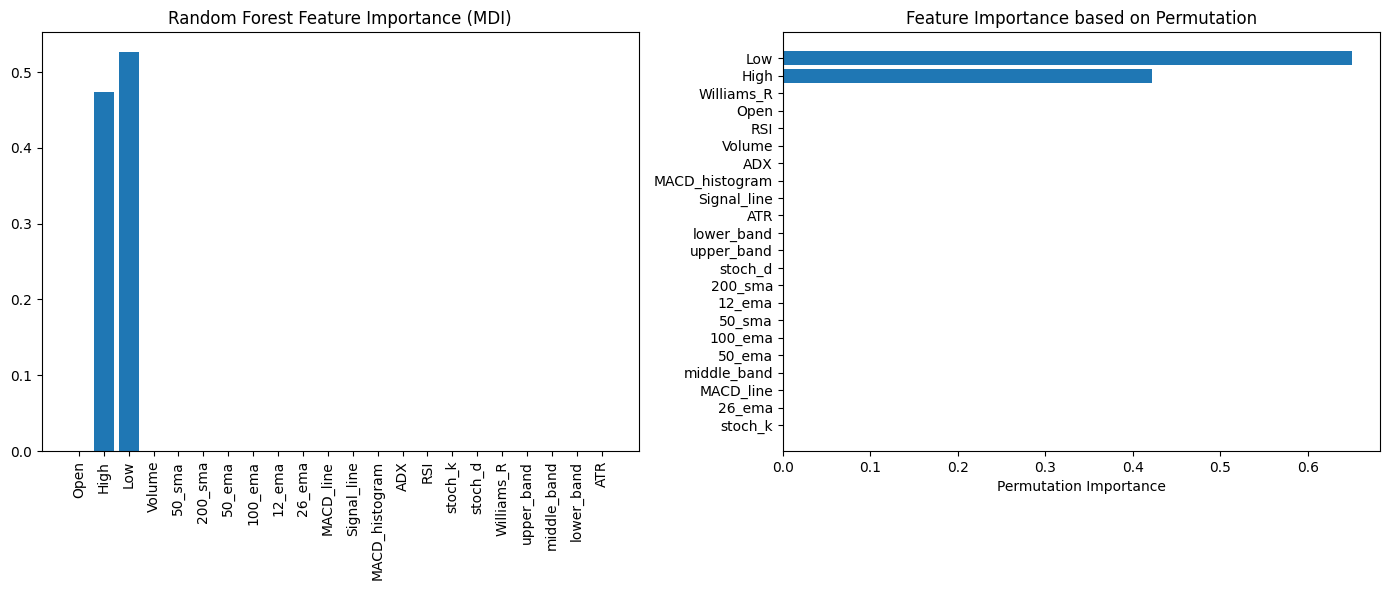

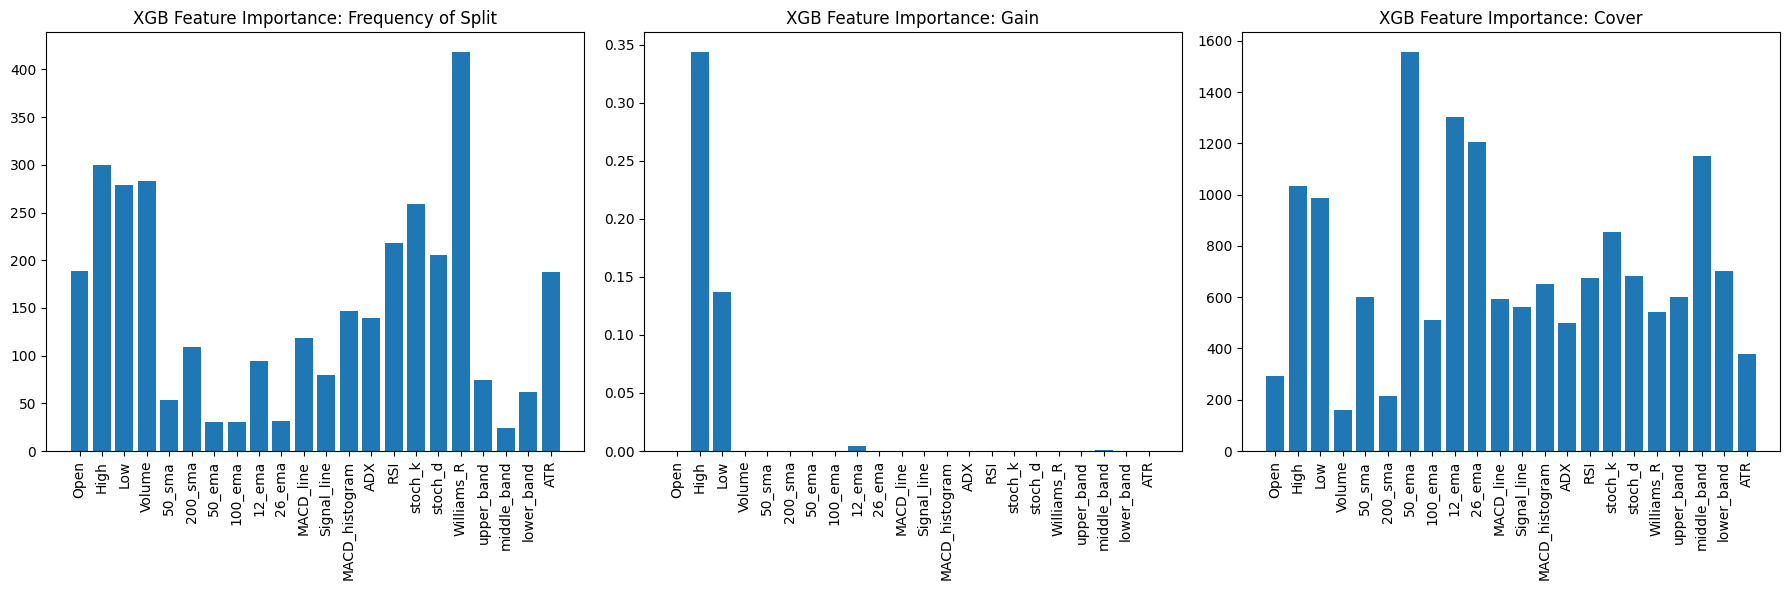

In [15]:
from sklearn.inspection import permutation_importance


# feature names, excluding 'Time' and 'Close'
names = ['Open', 'High', 'Low', 'Volume', '50_sma', '200_sma',
         '50_ema', '100_ema', '12_ema', '26_ema', 'MACD_line', 'Signal_line',
         'MACD_histogram', 'ADX', 'RSI', 'stoch_k', 'stoch_d', 'Williams_R',
         'upper_band', 'middle_band', 'lower_band', 'ATR']

# Fit random forest model

feature_values = multivariateDataset[names].values
respons_values = multivariateDataset['Close'].values
modelRF = RandomForestRegressor(n_estimators=10, random_state=1)
modelRF.fit(feature_values, respons_values)

# Plot side by side using subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot importance scores (Mean Decrease in Impurity)
ticks = [i for i in range(len(names))]
axs[0].bar(ticks, modelRF.feature_importances_)  # Score calculated based on Mean decrease in impurity
axs[0].set_title('Random Forest Feature Importance (MDI)')
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(names, rotation=90)

# Compute permutation importance- This a model agnostic approach to feature scoring : Apply to developed models as well
perm_importance = permutation_importance(modelRF, feature_values, respons_values, n_repeats=10, random_state=42)

# Sort and display the feature importance
sorted_idx = perm_importance.importances_mean.argsort()
axs[1].barh(np.array(names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
axs[1].set_title('Feature Importance based on Permutation')
axs[1].set_xlabel("Permutation Importance")

# Adjust layout to avoid overlap
plt.tight_layout()

plt.show()
'''
XGB :Feature score
'''

import xgboost as xgb
from xgboost import plot_importance

# fit model no training data
modelXGB = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
modelXGB.fit(feature_values, respons_values)

importance_scores = modelXGB.feature_importances_ #gain based feature score

ticks = [i for i in range(len(names))]
# Get the Booster object to access importance scores with different criteria
booster = modelXGB.get_booster()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of subplots

# Get feature importance based on 'weight' (frequency of splits)
importance_weight = booster.get_score(importance_type='weight')

axs[0].bar(ticks,  importance_weight.values())
axs[0].set_title('XGB Feature Importance: Frequency of Split')
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(names, rotation=90)

# Get feature importance based on 'gain' (average gain)
importance_gain = booster.get_score(importance_type='gain')

axs[1].bar(ticks, importance_gain.values())
axs[1].set_title('XGB Feature Importance: Gain')
axs[1].set_xticks(ticks)
axs[1].set_xticklabels(names, rotation=90)


# Get feature importance based on 'cover' (average coverage)
importance_cover = booster.get_score(importance_type='cover')

axs[2].bar(ticks, importance_cover.values())
axs[2].set_title('XGB Feature Importance: Cover')
axs[2].set_xticks(ticks)
axs[2].set_xticklabels(names, rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



# Generate multivariate laggged features

In [16]:
# reshape an input data into n_samples x timesteps x n_features.
# NOTE: data should be standardized

def multivariateFeatureLag(data, n_past, n_future, target_column=1):
    features = []
    response = []

    for i in range(n_past, len(data) - n_future + 1):
        # Extract the past n_past time steps as features
        features.append(data[i - n_past:i, :])  # Take all columns as features

        # Extract the target value (Close price in this case)
        response.append(data[i + n_future - 1, target_column])  # Extract the target column for response

    # Move the conversion to NumPy arrays outside the loop
    features = np.array(features)  # Convert to NumPy array after the loop finishes
    response = np.array(response)  # Convert to NumPy array after the loop finishes

    features_flat = features.reshape(features.shape[0], -1) # make shape 2d

    return features_flat, response

n_past = 3 
n_future = 1
target_col = 3
print(multivariateDataset.head())

multivariateDataset = multivariateDataset.to_numpy()

m_X, m_Y = multivariateFeatureLag(multivariateDataset,n_past, n_future, target_col )

feature_columns = [f'feature_{i}' for i in range(m_X.shape[1])]  # Name columns as 'feature_0', 'feature_1', ...
df_features = pd.DataFrame(m_X, columns=feature_columns)
df_response = pd.DataFrame(m_Y, columns=['Target'])

print(df_features.head())

      Open     High      Low    Close   Volume    50_sma   200_sma    50_ema  \
0  1.36200  1.36740  1.36173  1.36265    47969  1.287660  1.351287  1.299038   
1  1.36265  1.37360  1.34850  1.36175   740962  1.288950  1.350315  1.301497   
2  1.36175  1.36780  1.34305  1.34810  1102405  1.290123  1.349273  1.303324   
3  1.34810  1.36465  1.34180  1.35740   822123  1.290897  1.348278  1.305445   
4  1.35740  1.36385  1.34940  1.35270   920524  1.291523  1.347309  1.307298   

    100_ema    12_ema  ...  MACD_histogram        ADX        RSI    stoch_k  \
0  1.313298  1.320594  ...        0.011223  26.500387  72.838761  90.697924   
1  1.314257  1.326925  ...        0.010466  27.937534  72.357480  89.342702   
2  1.314927  1.330183  ...        0.008475  28.803357  65.309168  86.299069   
3  1.315768  1.334370  ...        0.007260  29.497963  67.623206  84.546555   
4  1.316500  1.337190  ...        0.005686  30.142955  65.254212  81.674148   

     stoch_d  Williams_R  upper_band  middle

# Forecasting with addtional features 

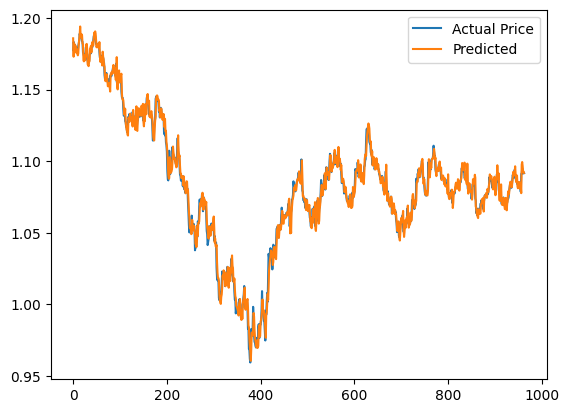

In [17]:
# data split 
m_x_train, m_x_test, m_train_y, m_test_y = train_test_split(m_X, m_Y, test_size=0.2, random_state=12, shuffle=False)

#Feature scaling - weigh each feature equally
scaler = StandardScaler()
m_x_train = scaler.fit_transform(m_x_train)
m_x_test = scaler.transform(m_x_test)

m_model = LinearRegression(learning_rate=0.01, n_iterations=1000)
m_model.fit(m_x_train, m_train_y)

#test set
m_predict = m_model.predict(m_x_test)

plt.plot(m_test_y, label= 'Actual Price')
plt.plot(m_predict, label ='Predicted')
plt.legend()
plt.show()



